# Model Training with WandB Versioned Data `[version 2]`

`model_training_w_wandb_versioned_data-[version 2]-refactor_input-and-output_artifact_config.ipynb`

Author: Jacob A Rose  
Created on: Wednesday May 12th, 2021

-----
Based on [this](https://colab.research.google.com/drive/1PRnwxttjPst6OmGiw9LDoVYRDApbcIjE) notebook (or see the original [report](https://wandb.ai/stacey/mendeleev/reports/DSViz-for-Image-Classification--VmlldzozNjE3NjA)), in which the [iNaturalist 2017](https://github.com/visipedia/inat_comp/tree/master/2017) dataset is re-sampled to several different versions, each with different #s of samples per class.
* These are then used to train and validate a keras model, then log many image predictions to W&B so that the versioned input images are directly associated with each new log. 
* This allows a flexible and scalable opportunity for researchers and even untrained members of the public to easily interact with the data and interrogate model decisions.

* Users can query subsets of the prediction results using basic logical queries w/ an effective autocomplete providing real-time suggestions for valid queries.

----------------------------


In [1]:
# from pathlib import Path
# from tqdm.notebook import trange, tqdm
# def get_labels_from_filepath(path: str, fix_catalog_number: bool = False):
#     """
    
#     """
#     family, genus, species, collection, catalog_number = Path(path).stem.split("_", maxsplit=4)
#     if fix_catalog_number:
#         catalog_number = '_'.join([collection, catalog_number])
#     return {"family":family,
#             "genus":genus,
#             "species":species,
#             "collection":collection,
#             "catalog_number":catalog_number}

# # construct a table containing our dataset
# def register_raw_dataset(dataset: torch.utils.data.Dataset,
#                          artifact,
#                          subset: str,
#                          fix_catalog_number: bool=False):
#     print(f"Registering {len(dataset.samples)} samples in {subset} subset")
#     table = wandb.Table(['image',
#                          'label', 
#                          "family",
#                          "genus",
#                          "species",
#                          "collection",
#                          "catalog_number"])
#     for sample in tqdm(dataset.samples):
#         path, label = sample        
#         metadata = get_labels_from_filepath(path, fix_catalog_number=fix_catalog_number)
#         rel_path = f"{subset}/{metadata['family']}/{Path(path).name}"
        
#         artifact.add_file(path, rel_path)
        
#         table.add_data(wandb.Image(path), label, *list(metadata.values()))
        
        
#     if hasattr(dataset, 'image_size'):
#         if isinstance(dataset.image_size, int):
#             artifact.metadata['image_size'] = dataset.image_size
        
        
#     artifact.metadata['num_samples'] = len(dataset.samples)
#     artifact.add(table, f'tables/{subset}')


## Step 2: Download data split artifact for input to training run

1. Access previously logged data artifact from Step 1

In [2]:
from pathlib import Path
import os
import wandb
os.environ['WANDB_CACHE_DIR'] = "/media/data/jacob/wandb_cache"
os.makedirs("/media/data/jacob/wandb_cache", exist_ok=True)
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
import numpy as np
import pytorch_lightning as pl
import torchvision
import torch
from torch import nn
import matplotlib.pyplot as plt
from contrastive_learning.data.pytorch.tensor import tensor_nbytes
from contrastive_learning.data.pytorch.pnas import PNASLightningDataModule
from contrastive_learning.data.pytorch.extant import ExtantLightningDataModule
from contrastive_learning.data.pytorch.common import DataStageError, colorbar, LeavesLightningDataModule
from contrastive_learning.data.pytorch.datamodules import get_datamodule, fetch_datamodule_from_dataset_artifact

from lightning_hydra_classifiers.callbacks.wandb_callbacks import LogPerClassMetricsToWandb, WandbClassificationCallback
from lightning_hydra_classifiers.models.resnet import ResNet
import lightning_hydra_classifiers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pl_bolts.callbacks import ModuleDataMonitor, BatchGradientVerificationCallback

import inspect
pl.trainer.seed_everything(seed=389)

from stuf import stuf
from box import Box
from rich import print as pp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


# image_size = 512
# class_type = 'family'
# thresholds = [100]
# seed = 894
# config = Box()

Global seed set to 389


Using device: cuda

TITAN X (Pascal)
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Dict Config commented out

In [3]:
# config.datasets = [{
#                   "name": f"PNAS_{class_type}_{thresholds[0]}_{image_size}",
#                   "batch_size":512,
#                   "val_split":None, # TODO specify split explicitly in wandb report
#                   "num_workers":4,
#                   "image_size":image_size,
#                   "channels":3,
#                   "class_type":class_type,
#                   "debug":False,
#                   "normalize":True,
#                   "seed":seed,
#                   "dataset_dir":None,
#                   "predict_on_split":"val",
#                   },
#     {
#                   "name":f"Extant_{class_type}_{extant_threshold}_{image_size}",  # f"PNAS_{label_type}_{pnas_threshold}_{image_size}"
#                   "batch_size":32,
#                   "val_split":None, # TODO specify split explicitly in wandb report
#                   "num_workers":4,
#                   "image_size":image_size,
#                   "channels":3,
#                   "class_type":class_type,
#                   "debug":False,
#                   "normalize":True,
#                   "seed":seed,
#                   "dataset_dir":None,
#                   "predict_on_split":"val",
#                   }]

# config.model = {
#                 "name":"resnet50",
#                 "num_classes":None,
#                 "input_shape": (config.dataset.channels, config.dataset.image_size, config.dataset.image_size),
#                 "optimizer":{'name':"Adam",
#                              'lr':0.01},
#                 "head":["avg_pool","flatten","fc"],
#                 "unfreeze":["layer4"],
#                 "checkpoint_dir":None
#                 }



# config.wandb = {
#                 "init":
#                        {},
#                 "artifacts":
#                        {"root_dir":None},
#                 "input_artifacts":
#                        [],
#                 "output_artifacts":
#                        []
#                 }


# config.wandb.init = {
#                      "entity":"jrose",
#                      "project":"image_classification_datasets",
# #                      "job_type":'create-dataset',
#                      "group":None,
#                      "run_dir":os.environ['WANDB_CACHE_DIR'],
#                      "tags":[d.name for d in config.datasets]
# }

# config.wandb.artifacts.root_dir = str(Path(config.wandb.init.run_dir, 'artifacts'))
# config.wandb.input_artifacts.append(
#                                     {
#                                     "tags":["input_dataset"],
#                                     "entity":"jrose",
#                                     "project":"image_classification_datasets",
#                                     "name": config.datasets[0].name,
#                                     "version": "v6",
#                                     "type": "raw_data",
#                                     "uri":None,
#                                     "root_dir":str(Path(config.wandb.artifacts.root_dir,
#                                                         "inputs", "dataset",
#                                                         config.datasets[0].name))
#                                     },
#                                     {
#                                     "tags":["input_model"],
#                                     "basename": config.model.name,
#                                     "name": config.model.name + "_init"
#                                     "version":"latest",
#                                     "type":"imagenet-init-model",
#                                     "description":f"imagenet-pretrained ResNet50 base model -> avg_pool -> randomly initiated 1x fc output layer w/ size=num_classes",
#                                     "root_dir":None 
#                                     }
#                                     )
        
# config.wandb.output_artifacts.append({
#                                     "root_dir":str(Path(config.wandb.artifacts.root_dir,
#                                                         "outputs", "model",
#                                                         config.datasets[0].name)),
#                                       "output_model_dir": str(Path(config.wandb.model_artifact.root_dir,
#                                                           f"{config.dataset.name}_trained")),
#                                     output_model_path = os.path.join(config.output_artifacts.output_model_dir, "best_model.pt")
#                                     output_name = config.output_artifacts.basename + "_output"


# config.dataset.dataset_dir = config.wandb.input_artifact.root_dir

    
    
    
    

### Dataclass Configs

In [4]:
from dataclasses import dataclass, field, asdict, astuple, InitVar
from typing import Tuple, List, Dict, Any, Type, Union
from enum import Enum
from pprint import pprint as pp

class ArtifactType(Enum):
    InputArtifact = "in"
    OutputArtifact = "out"
    
# TBD: Integrate this Enum if it seems worthwhile
# class JobType(Enum):
#     create_dataset = "create_dataset"
#     train = "train"
#     test = "test"
    
class ModelStage(Enum):
    random_init = "rand_init"
    imagenet_init = "init"
    train = "train"
    feature_extractor = "feature extractor"
    finetune = "finetune"
    continual = "continual"

import typing
    
    
class TypeEnum(Enum):
#     typing.Tuple = tuple
    List = list
    Dict = dict
    Any = (lambda x: x)
    
    @classmethod
    def is_builtin(cls, key: Union[str,Type]):
#         if str(key).split('.')[-1] in cls.__members__:
        try:
            cls.parse(key)
            return True
        except:
            return False

    @classmethod
    def parse(cls, key: Union[str,Type]):
        parsed_key = str(key).split('.')[-1].split('[')[0]
        return cls.__members__[parsed_key]

    
    
@dataclass
class BaseConfig:

    def asdict(self):
        return asdict(self)
    
    def astuple(self):
        return astuple(self)

    @classmethod
    def from_dict(cls, config_dict: Dict[str,Any]):
        input_kwargs = config_dict # .asdict()
        sig = inspect.signature(cls) # SimpleExperimentConfig)

        signature_kwargs = dict(sig.parameters)

        for key in list(signature_kwargs.keys()):
            if key in input_kwargs:
                type_init = signature_kwargs[key].annotation
                if hasattr(input_kwargs[key], "asdict"):
                    input_kwargs[key] = input_kwargs[key].asdict()
                if TypeEnum.is_builtin(type_init):
                    type_init = TypeEnum.parse(type_init)
                elif hasattr(type_init,'from_dict'):
                    signature_kwargs[key] = type_init.from_dict(input_kwargs[key])
                elif isinstance(input_kwargs[key], dict):
                    signature_kwargs[key] = type_init(**input_kwargs[key])
                elif input_kwargs[key] == None:
                    signature_kwargs[key] = input_kwargs[key]
                else:
                    signature_kwargs[key] = type_init(input_kwargs[key])
        return cls(**signature_kwargs)





@dataclass
class OptimizerConfig(BaseConfig):
    name: str = "Adam"
    lr: float = 0.01
    weight_decay: float = 0.0

@dataclass
class ModelConfig(BaseConfig):

    name: str = "resnet50"
    num_classes: int = 0
    input_shape: tuple = (3,None,None)
    optimizer: OptimizerConfig = field(default_factory=OptimizerConfig)
    head: list = None # field(default_factory=lambda : ["avg_pool","flatten","fc"])
    unfreeze: list = ("layer4",) # field(default_factory=lambda : ["layer4"])
    root_dir: str = field(default=None)
    model_dir: str = field(default=None) #, init=False)
    model_path: str = field(default=None) #, init=False)
        
    def __post_init__(self):
        if self.root_dir is None:
            self.root_dir = os.path.join(os.environ["WANDB_CACHE_DIR"],'artifacts')
        
        if self.head is None:
            self.head = ["avg_pool","flatten","fc"]
            


        self.model_dir = os.path.join(self.root_dir, 'models', self.name) #, self.model_stage.value)
        self.model_path = os.path.join(self.model_dir, "best_model.ckpt")

        
        
        
        
@dataclass
class DatasetConfig(BaseConfig):

    name: str = field(default="Extant_family_10_512")
    batch_size: int = 64
    val_split: float = field(default=0.0) # TODO specify split explicitly in wandb report
    image_size: int = 512
    channels: int = 3
    class_type: str = "family"
    normalize: bool = True
    seed: int = 253
    predict_on_split: str = field(default="val")
    debug: bool = False
    num_workers: int = 4
    root_dir: str = field(default=None)
#     dataset_dir: str = field(init=False) #default=None)
        
    def __post_init__(self):
        if self.root_dir is None:
            self.root_dir = os.path.join(os.environ["WANDB_CACHE_DIR"],'artifacts')
        self.dataset_dir = os.path.join(self.root_dir, 'datasets', self.name)


# opt_cfg = OptimizerConfig(lr=1e-4)
# model_cfg = ModelConfig(optimizer=opt_cfg, unfreeze="layer3")#["layer3", "layer4"])

        
@dataclass
class ArtifactConfig(BaseConfig):
    basename: str = None
    name: str = None
    project: str = None
    entity: str = None
    version: str = 'latest'
#     uri: str = field(default="", init=False)
#     model_type: str = field(default=None)#"imagenet-init-model")
    artifact_type: ArtifactType = None #field(default=None)
    description: str = None #field(default=None)
    root_dir: str = None # field(default=None)
        
    def __post_init__(self):
        if self.root_dir is None:
            self.root_dir = os.path.join(os.environ["WANDB_CACHE_DIR"],'artifacts')#, 'models', self.basename)
        if self.basename is None and self.name is not None:
            self.basename = self.name.split("_", maxsplit=1)
        elif self.name is None and self.basename is not None:
            self.name = self.basename

        self.uri = self.get_uri()
        
            
    def get_uri(self,
                name: str = None,
                project: str = None,
                entity: str = None,
                version: str = 'latest'):
        name = name or self.name
        project = project or self.project
        entity = entity or self.entity
        version = version or self.version
        
        uri = name + f":{version}"
        if project:
            uri = "/".join([project, uri])
            if entity:
                uri = "/".join([entity, uri])
        return uri

@dataclass
class ModelArtifactConfig(ArtifactConfig):

    model_type: str = field(default=None)#"imagenet-init-model")
    model_stage: ModelStage = field(default=ModelStage.imagenet_init)
    model_dir: str = field(default=None) #, init=False)
    model_path: str = field(default=None) #, init=False)
    datasets_seen: list = None #field(default_factory=list)

    def __post_init__(self):
        self.name = self.basename + f"_{self.model_stage.value}"
        if self.datasets_seen is None:
            self.datasets_seen = []
        if len(self.datasets_seen)>0:
            self.name = "_".join([self.name, *self.datasets_seen])
        super().__post_init__()
        self.model_dir = os.path.join(self.root_dir, 'models', self.basename, self.model_stage.value)
        self.model_path = os.path.join(self.model_dir, "best_model.ckpt")
        self.model_type = "_".join([*self.datasets_seen, f"{self.model_stage.value}_model"])

        
@dataclass
class InputModelArtifactConfig(ModelArtifactConfig):

    model_stage: ModelStage = field(default=ModelStage.imagenet_init)
    artifact_type: ArtifactType = field(default=ArtifactType.InputArtifact)
        
@dataclass
class OutputModelArtifactConfig(ModelArtifactConfig):

    model_stage: ModelStage = field(default=ModelStage.train)
    artifact_type: ArtifactType = field(default=ArtifactType.OutputArtifact)



# input_model_artifact_cfg = InputModelArtifactConfig('resnet50')
# output_model_artifact_cfg = OutputModelArtifactConfig('resnet50')
# pp(input_model_artifact_cfg, output_model_artifact_cfg)

@dataclass
class DatasetArtifactConfig(ArtifactConfig):
    
    dataset_dir: str = field(default=None)
        
    def __post_init__(self):        
        
        if self.root_dir is None:
            self.root_dir = os.path.join(os.environ["WANDB_CACHE_DIR"],'artifacts', 'datasets')
        super().__post_init__()
        self.dataset_dir = os.path.join(self.root_dir, self.name)
        
        
@dataclass
class InputDatasetArtifactConfig(ArtifactConfig):
    artifact_type: ArtifactType = field(default=ArtifactType.InputArtifact)
        
        
# Currently no specific use for OutputDatasetArtifactConfig since  most typical training pipelines must input data far more often than they output it.,
# but the definition is included for completeness + conceptual symmetry with Model In/Out artifacts + futureproofing.
        
@dataclass
class OutputDatasetArtifactConfig(ArtifactConfig):
    artifact_type: ArtifactType = field(default=ArtifactType.OutputArtifact)


# input_dataset_artifact_cfg = InputDatasetArtifactConfig(basename="PNAS")
# pp(input_dataset_artifact_cfg)

@dataclass
class WandBInitConfig:

    entity: str = "jrose"
    project: str = "image_classification"
    job_type: str = "train"
    group: str = "stage_0"
    run_dir: str = os.environ['WANDB_CACHE_DIR']
    tags: set = None

#     _tags: set = None #field(init=False, default_factory=set)
        
    def __post_init__(self):
        if self.tags is None:
            self.tags = set()
#         self.tags = set() if self.tags is None else set(self.tags)

#     @property
#     def tags(self):
#         return self._tags
    
#     @tags.setter
#     def tags(self, new_tags: set):
#         self._tags = self.tags.union(set(new_tags))




@dataclass
class TrainerConfig:
    gpus: int = 1
    max_epochs: int = 40
    log_every_n_steps: int = 50
    weights_summary: str = "top"
    profiler: str = "simple"
    auto_scale_batch_size: str = field(default=False) #"power", # "binsearch" # None
    auto_lr_find: bool = field(default=False)
    auto_lr_num_samples: int = 100

# init_cfg = WandBInitConfig()
# trainer_cfg = TrainerConfig()
# pp(init_cfg,trainer_cfg)

In [9]:
from typing import Dict, Any

@dataclass
class SimpleExperimentConfig(BaseConfig):
    
    wandb_init: WandBInitConfig
    trainer: TrainerConfig
    
    dataset: DatasetConfig
    model: ModelConfig
    input_dataset_artifact: InputDatasetArtifactConfig
    input_model_artifact: InputModelArtifactConfig
    output_model_artifact: OutputModelArtifactConfig

    def __post_init__(self):
        
        self.model.input_shape = (self.dataset.channels, self.dataset.image_size, self.dataset.image_size)        
        self.wandb_init.tags.union({self.model.name, self.dataset.name})

#     def asdict(self):
#         return asdict(self)
    
#     def astuple(self):
#         return astuple(self)

In [10]:
#     @classmethod
#     def from_dict(cls, data_dict: Dict[str,Any]):

#         sig = inspect.signature(cls)#SimpleExperimentConfig)
#         kwargs = {}

#         for key, param in sig.parameters.items():
#     #     for k, v in data_dict.items():
#             if sig.parameters[key].annotation != inspect._empty:
#                 kwargs[key] = param.annotation(**data_dict[key])
#                 print(f'Added {key} to kwargs by converting them to a {param} first')

#         return cls(**kwargs)
#     print(k, f'type(v): {type(v)}', v.annotation,'\n')

    
    
    
    
# model_cfg_factory = sig.parameters['model'].annotation
# model_cfg_factory(**experiment_cfg_2.model)

# inspect.signature(param.annotation)

# test = SimpleExperimentConfig.from_dict(exp_dict_cfg)
# pp(test)

# dir(experiment_cfg_2)
# experiment_cfg_2.__dataclass_fields__.keys()
# experiment_cfg_2.wandb_init.keys()
# # experiment_cfg_2.__dataclass_fields__.keys()
# SimpleExperimentConfig.__dataclass_fields__.keys()
# for k,v in SimpleExperimentConfig.__dataclass_fields__.items():
#     print(k, type(v), '\n')
# dir(v)
# v.metadata

In [11]:
from rich import print as pp

wandb_init_cfg = WandBInitConfig()
trainer_cfg = TrainerConfig()
dataset_cfg = DatasetConfig(name="Extant_family_10_512",
                            batch_size = 64,
                            val_split = 0.0,
                            image_size = 512,
                            channels = 3,
                            class_type = "family",
                            normalize = True,
                            seed = 253,
                            predict_on_split = "val",
                            debug = False,
                            num_workers = 4,
                            root_dir = None)

opt_cfg = OptimizerConfig(name="Adam", lr=1e-4)
model_cfg = ModelConfig(optimizer=opt_cfg, unfreeze=["layer4"])#["layer3", "layer4"])


input_dataset_artifact_cfg = InputDatasetArtifactConfig(basename="PNAS")
input_model_artifact_cfg = InputModelArtifactConfig(basename='resnet50')
output_model_artifact_cfg = OutputModelArtifactConfig(basename='resnet50')

In [12]:
experiment_cfg = SimpleExperimentConfig(wandb_init=wandb_init_cfg,
                                        trainer=trainer_cfg,
                                        dataset=dataset_cfg,
                                        model=model_cfg,
                                        input_dataset_artifact=input_dataset_artifact_cfg,
                                        input_model_artifact=input_model_artifact_cfg,
                                        output_model_artifact=output_model_artifact_cfg)

In [13]:
pp(experiment_cfg.asdict())

recon = SimpleExperimentConfig.from_dict(experiment_cfg.asdict())

{
    'wandb_init': {
        'entity': 'jrose',
        'project': 'image_classification',
        'job_type': 'train',
        'group': 'stage_0',
        'run_dir': '/media/data/jacob/wandb_cache',
        'tags': set()
    },
    'trainer': {
        'gpus': 1,
        'max_epochs': 40,
        'log_every_n_steps': 50,
        'weights_summary': 'top',
        'profiler': 'simple',
        'auto_scale_batch_size': False,
        'auto_lr_find': False,
        'auto_lr_num_samples': 100
    },
    'dataset': {
        'name': 'PNAS_family_100_512',
        'batch_size': 64,
        'val_split': 0.0,
        'image_size': 512,
        'channels': 3,
        'class_type': 'family',
        'normalize': True,
        'seed': 253,
        'predict_on_split': 'val',
        'debug': False,
        'num_workers': 4,
        'root_dir': '/media/data/jacob/wandb_cache/artifacts'
    },
    'model': {
        'name': 'resnet50',
        'num_classes': 0,
        'input_shape': (3, 512, 512),
        'optimizer': {'name': 'Adam', 'lr': 0.0001, 'weight_decay': 0.0},
        'head': ['avg_pool', 'flatten', 'fc'],
        'unfreeze': ['layer4'],
        'root_dir': '/media/data/jacob/wandb_cache/artifacts',
        'model_dir': '/media/data/jacob/wandb_cache/artifacts/models/resnet50',
        'model_path': 
'/media/data/jacob/wandb_cache/artifacts/models/resnet50/best_model.ckpt'
    },
    'input_dataset_artifact': {
        'basename': 'PNAS',
        'name': 'PNAS',
        'project': None,
        'entity': None,
        'version': 'latest',
        'artifact_type': <ArtifactType.InputArtifact: 'in'>,
        'description': None,
        'root_dir': '/media/data/jacob/wandb_cache/artifacts'
    },
    'input_model_artifact': {
        'basename': 'resnet50',
        'name': 'resnet50_init',
        'project': None,
        'entity': None,
        'version': 'latest',
        'artifact_type': <ArtifactType.InputArtifact: 'in'>,
        'description': None,
        'root_dir': '/media/data/jacob/wandb_cache/artifacts',
        'model_type': 'init_model',
        'model_stage': <ModelStage.imagenet_init: 'init'>,
        'model_dir': '/media/data/jacob/wandb_cache/artifacts/models/resnet50/init',
        'model_path': 
'/media/data/jacob/wandb_cache/artifacts/models/resnet50/init/best_model.ckpt',
        'datasets_seen': []
    },
    'output_model_artifact': {
        'basename': 'resnet50',
        'name': 'resnet50_train',
        'project': None,
        'entity': None,
        'version': 'latest',
        'artifact_type': <ArtifactType.OutputArtifact: 'out'>,
        'description': None,
        'root_dir': '/media/data/jacob/wandb_cache/artifacts',
        'model_type': 'train_model',
        'model_stage': <ModelStage.train: 'train'>,
        'model_dir': '/media/data/jacob/wandb_cache/artifacts/models/resnet50/train',
        'model_path': 
'/media/data/jacob/wandb_cache/artifacts/models/resnet50/train/best_model.ckpt',
        'datasets_seen': []
    }
}

In [14]:
pp(recon.model)

pp(experiment_cfg.model)

ModelConfig(
    name='resnet50',
    num_classes=0,
    input_shape=(3, 512, 512),
    optimizer=OptimizerConfig(name='Adam', lr=0.0001, weight_decay=0.0),
    head=['avg_pool', 'flatten', 'fc'],
    unfreeze=['layer4'],
    root_dir='/media/data/jacob/wandb_cache/artifacts',
    model_dir='/media/data/jacob/wandb_cache/artifacts/models/resnet50',
    model_path='/media/data/jacob/wandb_cache/artifacts/models/resnet50/best_model.ckpt'
)

ModelConfig(
    name='resnet50',
    num_classes=0,
    input_shape=(3, 512, 512),
    optimizer=OptimizerConfig(name='Adam', lr=0.0001, weight_decay=0.0),
    head=['avg_pool', 'flatten', 'fc'],
    unfreeze=['layer4'],
    root_dir='/media/data/jacob/wandb_cache/artifacts',
    model_dir='/media/data/jacob/wandb_cache/artifacts/models/resnet50',
    model_path='/media/data/jacob/wandb_cache/artifacts/models/resnet50/best_model.ckpt'
)

In [16]:
# tags = set()
# tags = tags.union({"pnas"})
# print(tags)
# tags = tags.union({"extant"})
# print(tags)

print(f'All equal: {experiment_cfg==recon}')
print(f'All equal as_dict: {experiment_cfg.asdict()==recon.asdict()}')


for k,v in experiment_cfg.asdict().items():
    print(k)
    print(f'Reconstructed:')
    pp(recon.asdict()[k])
    print('Original:')
    pp(v)
    
    print(f'Equal: {v==recon.asdict()[k]}')

All equal: True
All equal as_dict: True
wandb_init
Reconstructed:


{
    'entity': 'jrose',
    'project': 'image_classification',
    'job_type': 'train',
    'group': 'stage_0',
    'run_dir': '/media/data/jacob/wandb_cache',
    'tags': set()
}

Original:


{
    'entity': 'jrose',
    'project': 'image_classification',
    'job_type': 'train',
    'group': 'stage_0',
    'run_dir': '/media/data/jacob/wandb_cache',
    'tags': set()
}

Equal: True
trainer
Reconstructed:


{
    'gpus': 1,
    'max_epochs': 40,
    'log_every_n_steps': 50,
    'weights_summary': 'top',
    'profiler': 'simple',
    'auto_scale_batch_size': False,
    'auto_lr_find': False,
    'auto_lr_num_samples': 100
}

Original:


{
    'gpus': 1,
    'max_epochs': 40,
    'log_every_n_steps': 50,
    'weights_summary': 'top',
    'profiler': 'simple',
    'auto_scale_batch_size': False,
    'auto_lr_find': False,
    'auto_lr_num_samples': 100
}

Equal: True
dataset
Reconstructed:


{
    'name': 'PNAS_family_100_512',
    'batch_size': 64,
    'val_split': 0.0,
    'image_size': 512,
    'channels': 3,
    'class_type': 'family',
    'normalize': True,
    'seed': 253,
    'predict_on_split': 'val',
    'debug': False,
    'num_workers': 4,
    'root_dir': '/media/data/jacob/wandb_cache/artifacts'
}

Original:


{
    'name': 'PNAS_family_100_512',
    'batch_size': 64,
    'val_split': 0.0,
    'image_size': 512,
    'channels': 3,
    'class_type': 'family',
    'normalize': True,
    'seed': 253,
    'predict_on_split': 'val',
    'debug': False,
    'num_workers': 4,
    'root_dir': '/media/data/jacob/wandb_cache/artifacts'
}

Equal: True
model
Reconstructed:


{
    'name': 'resnet50',
    'num_classes': 0,
    'input_shape': (3, 512, 512),
    'optimizer': {'name': 'Adam', 'lr': 0.0001, 'weight_decay': 0.0},
    'head': ['avg_pool', 'flatten', 'fc'],
    'unfreeze': ['layer4'],
    'root_dir': '/media/data/jacob/wandb_cache/artifacts',
    'model_dir': '/media/data/jacob/wandb_cache/artifacts/models/resnet50',
    'model_path': '/media/data/jacob/wandb_cache/artifacts/models/resnet50/best_model.ckpt'
}

Original:


{
    'name': 'resnet50',
    'num_classes': 0,
    'input_shape': (3, 512, 512),
    'optimizer': {'name': 'Adam', 'lr': 0.0001, 'weight_decay': 0.0},
    'head': ['avg_pool', 'flatten', 'fc'],
    'unfreeze': ['layer4'],
    'root_dir': '/media/data/jacob/wandb_cache/artifacts',
    'model_dir': '/media/data/jacob/wandb_cache/artifacts/models/resnet50',
    'model_path': '/media/data/jacob/wandb_cache/artifacts/models/resnet50/best_model.ckpt'
}

Equal: True
input_dataset_artifact
Reconstructed:


{
    'basename': 'PNAS',
    'name': 'PNAS',
    'project': None,
    'entity': None,
    'version': 'latest',
    'artifact_type': <ArtifactType.InputArtifact: 'in'>,
    'description': None,
    'root_dir': '/media/data/jacob/wandb_cache/artifacts'
}

Original:


{
    'basename': 'PNAS',
    'name': 'PNAS',
    'project': None,
    'entity': None,
    'version': 'latest',
    'artifact_type': <ArtifactType.InputArtifact: 'in'>,
    'description': None,
    'root_dir': '/media/data/jacob/wandb_cache/artifacts'
}

Equal: True
input_model_artifact
Reconstructed:


{
    'basename': 'resnet50',
    'name': 'resnet50_init',
    'project': None,
    'entity': None,
    'version': 'latest',
    'artifact_type': <ArtifactType.InputArtifact: 'in'>,
    'description': None,
    'root_dir': '/media/data/jacob/wandb_cache/artifacts',
    'model_type': 'init_model',
    'model_stage': <ModelStage.imagenet_init: 'init'>,
    'model_dir': '/media/data/jacob/wandb_cache/artifacts/models/resnet50/init',
    'model_path': 
'/media/data/jacob/wandb_cache/artifacts/models/resnet50/init/best_model.ckpt',
    'datasets_seen': []
}

Original:


{
    'basename': 'resnet50',
    'name': 'resnet50_init',
    'project': None,
    'entity': None,
    'version': 'latest',
    'artifact_type': <ArtifactType.InputArtifact: 'in'>,
    'description': None,
    'root_dir': '/media/data/jacob/wandb_cache/artifacts',
    'model_type': 'init_model',
    'model_stage': <ModelStage.imagenet_init: 'init'>,
    'model_dir': '/media/data/jacob/wandb_cache/artifacts/models/resnet50/init',
    'model_path': 
'/media/data/jacob/wandb_cache/artifacts/models/resnet50/init/best_model.ckpt',
    'datasets_seen': []
}

Equal: True
output_model_artifact
Reconstructed:


{
    'basename': 'resnet50',
    'name': 'resnet50_train',
    'project': None,
    'entity': None,
    'version': 'latest',
    'artifact_type': <ArtifactType.OutputArtifact: 'out'>,
    'description': None,
    'root_dir': '/media/data/jacob/wandb_cache/artifacts',
    'model_type': 'train_model',
    'model_stage': <ModelStage.train: 'train'>,
    'model_dir': '/media/data/jacob/wandb_cache/artifacts/models/resnet50/train',
    'model_path': 
'/media/data/jacob/wandb_cache/artifacts/models/resnet50/train/best_model.ckpt',
    'datasets_seen': []
}

Original:


{
    'basename': 'resnet50',
    'name': 'resnet50_train',
    'project': None,
    'entity': None,
    'version': 'latest',
    'artifact_type': <ArtifactType.OutputArtifact: 'out'>,
    'description': None,
    'root_dir': '/media/data/jacob/wandb_cache/artifacts',
    'model_type': 'train_model',
    'model_stage': <ModelStage.train: 'train'>,
    'model_dir': '/media/data/jacob/wandb_cache/artifacts/models/resnet50/train',
    'model_path': 
'/media/data/jacob/wandb_cache/artifacts/models/resnet50/train/best_model.ckpt',
    'datasets_seen': []
}

Equal: True


In [24]:
# @dataclass
# class ModelArtifactConfig(ArtifactConfig):

#     basename: str = 'resnet50'
#     name: str = field(default=None)
#     project: str = field(default=None)
#     entity: str = field(default=None)
#     version: str = 'latest'
#     uri: str = field(default="", init=False)
#     model_type: str = field(default=None)#"imagenet-init-model")
#     model_stage: ModelStage = field(default=ModelStage.imagenet_init)
#     model_dir: str = field(init=False)
#     model_path: str = field(init=False)
#     datasets_seen: List = field(default_factory=list)
#     artifact_type: ArtifactType = field(default=None)#ArtifactType.InputArtifact
#     description: str = field(default=None)
#     root_dir: str = field(default=None)

#     def __post_init__(self):
#         self.name = self.basename + f"_{self.model_stage.value}"
#         if len(self.datasets_seen)>0:
#             self.name = "_".join([self.name, *self.datasets_seen])
#         super().__post_init__()
#         self.model_dir = os.path.join(self.root_dir, self.model_stage.value)
#         self.model_path = os.path.join(self.model_dir, "best_model.ckpt")

#         self.model_type = "_".join([*self.datasets_seen, f"{self.model_stage.value}_model"])

# @dataclass
# class ModelArtifactConfig:
        
#     basename: str = 'resnet50'
    
#     name: str = field(default=None)
#     project: str = field(default=None)
#     entity: str = field(default=None)
#     version: str = 'latest'
#     uri: str = field(default="", init=False)
        
#     model_type: str = field(default=None)#"imagenet-init-model")
#     artifact_type: ArtifactType = field(default=None)#ArtifactType.InputArtifact
#     description: str = field(default=None)
#     root_dir: str = field(default=None)
        
        
#     def __post_init__(self):
#         if self.root_dir is None:
#             self.root_dir = os.path.join(os.environ["WANDB_CACHE_DIR"],'artifacts', 'models', self.basename)

#         if self.name is None:
#             self.name = self.basename

#         self.uri = self.name + f":{self.version}"
#         if self.project:
#             self.uri = "/".join([self.project, self.uri])
#             if self.entity:
#                 self.uri = "/".join([self.entity, self.uri])

# model_artifact_cfg = ModelArtifactConfig(entity="jrose", project="image_classification")
# model_artifact_cfg

# @dataclass
# class InputModelArtifactConfig(ModelArtifactConfig):

#     name: str = field(init=False)
#     model_type: str = field(default="imagenet-init-model")
#     model_dir: str = field(init=False)
#     artifact_type: ArtifactType = field(default=ArtifactType.InputArtifact)
        
#     def __post_init__(self):
#         self.name = self.basename + "_init"
        
#         super().__post_init__()
#         self.model_dir = os.path.join(self.root_dir, "init") #"models", self.basename + "_init")
        
        
# @dataclass
# class OutputModelArtifactConfig(ModelArtifactConfig):

#     name: str = field(init=False)
#     model_type: str = field(default="PNAS-trained-model")
#     model_dir: str = field(init=False)
#     artifact_type: ArtifactType = field(default=ArtifactType.OutputArtifact)
    
#     def __post_init__(self):
#         self.name = self.basename + "_trained"
        
#         super().__post_init__()
#         self.model_dir = os.path.join(self.root_dir, "trained")
#         self.model_path = os.path.join(self.model_dir, "best_model.ckpt")
        
        
        
        
# #     output_model_dir: '/media/data/jacob/wandb_cache/artifacts/models/resnet50:v0/Extant_family_10_512_trained',
# #     output_model_path: '/media/data/jacob/wandb_cache/artifacts/models/resnet50:v0/Extant_family_10_512_trained/best.ckpt',
# #     output_name: 'resnet50_output'
# #     output_type: 'Extant_trained_model',



# input_model_artifact_cfg = InputModelArtifactConfig()

# output_model_artifact_cfg = OutputModelArtifactConfig()

# pp(input_model_artifact_cfg, output_model_artifact_cfg)

In [2]:
# config.wandb = {
#                 "init":
#                        {
#                         "entity":"jrose",
#                         "project":"image_classification_datasets",
#                         "job_type":'create-dataset',
#                         "group":None,
#                         "run_dir":os.environ['WANDB_CACHE_DIR'],
#                         "tags":[d.name for d in config.datasets]
#                        },
#                 "artifacts":
#                         {
#                         "root_dir":None
#                         },
#                 "input_artifacts":
#                        [
#                            {
#                             "entity":"jrose",
#                             "project":"image_classification_datasets",
#                             "name": config.datasets[0].name,
#                             "version": "v6",
#                             "type": "raw_data",
#                             "root_dir":None,
#                             "uri":None
#                            }
#                        ]
# }


# config.dataset = {
#                   "name":"PNAS_family_100_1024",
#                   "batch_size":512,
#                   "val_split":None, # TODO specify split explicitly in wandb report
#                   "num_workers":4,
#                   "image_size":1024,
#                   "channels":3,
#                   "class_type":"family",
#                   "debug":False,
#                   "normalize":True,
#                   "seed":389,
#                   "dataset_dir":None,
#                   "predict_on_split":"val",
#                   }

In [4]:
# config.dataset = {
#                   "name":"Extant_family_10_512",
#                   "batch_size":64,
#                   "val_split":None, # TODO specify split explicitly in wandb report
#                   "num_workers":4,
#                   "image_size":512,
#                   "channels":3,
#                   "class_type":"family",
#                   "debug":False,
#                   "normalize":True,
#                   "seed":389,
#                   "dataset_dir":None,
#                   "predict_on_split":"val",
#                   }


# #####################################

# config.model = {
#                 "name":"resnet50",
#                 "num_classes":None,
#                 "input_shape": (config.dataset.channels, config.dataset.image_size, config.dataset.image_size),
#                 "optimizer":{'name':"Adam", 'lr':0.01},
#                 "head":["avg_pool","flatten","fc"],
#                 "unfreeze":["layer4"],
#                 "checkpoint_dir":None
#                 }

# config.trainer = {
#                   "gpus":1,
#                   "max_epochs":40,
#                   "log_every_n_steps":50,
#                   "weights_summary":"top",
#                   "profiler":"simple",
#                   "auto_scale_batch_size":"power", # "binsearch" # None
#                   "auto_lr_find":True,
#                   "auto_lr_num_samples":50
#                   }



# config.wandb = {
#                 "init":
#                        {
#                         "entity":"jrose",
#                         "project":"image_classification",
#                         "job_type":"train",
#                         "group":"stage_0",
#                         "run_dir":os.environ['WANDB_CACHE_DIR'],
#                         "tags":[config.dataset.name]
#                        },
#                 "artifacts":
#                         {
#                         "root_dir":None
#                         },
#                 "input_artifact":
#                        {
#                         "entity":"jrose",
#                         "project":"image_classification_datasets",
#                         "name": config.dataset.name,
#                         "version": "latest", #"v1",
#                         "type": "raw_data",
#                         "root_dir":None
#                        },
#                 "model_artifact":
#                         {
#                          "basename": config.model.name,
#                          "version":"v0",
#                          "input_type":"imagenet-init-model",
#                          "output_type":f'{config.dataset.name.split("_")[0]}_trained_model',
#                          "description":"imagenet-pretrained ResNet50 base model -> avg_pool -> 1 fc output layer w/ size=num_classes",
#                          "root_dir":None
#                         }
#     }

# config.wandb.input_artifact.uri = "/".join([config.wandb.input_artifact.entity,
#                                             config.wandb.input_artifact.project,
#                                             config.wandb.input_artifact.name]) \
#                                    + f':{config.wandb.input_artifact.version}'

# config.wandb.artifacts.root_dir = os.path.join(*[config.wandb.init.run_dir,
#                                                 "artifacts"])

# config.wandb.input_artifact.root_dir = os.path.join(*[config.wandb.artifacts.root_dir,
#                                                      "datasets",
#                                                      config.wandb.input_artifact.name \
#                                                  + f':{config.wandb.input_artifact.version}'
#                                                     ])


# config.wandb.model_artifact.root_dir = os.path.join(*[config.wandb.artifacts.root_dir,
#                                                      "models",
#                                                      config.wandb.model_artifact.basename \
#                                                  + f':{config.wandb.model_artifact.version}'
#                                                     ])
# config.wandb.model_artifact.init_model_dir = os.path.join(*[config.wandb.model_artifact.root_dir,
#                                                             'init'
#                                                            ])
# config.wandb.model_artifact.output_model_dir = str(Path(config.wandb.model_artifact.root_dir,
#                                                     f"{config.dataset.name}_trained"))

# config.wandb.model_artifact.output_model_path = os.path.join(config.wandb.model_artifact.output_model_dir, "best.ckpt")

# config.wandb.model_artifact.init_name = config.wandb.model_artifact.basename + "_init"
# config.wandb.model_artifact.output_name = config.wandb.model_artifact.basename + "_output"


# config.dataset.dataset_dir = config.wandb.input_artifact.root_dir
# config.model.checkpoint_dir = os.path.join(config.wandb.model_artifact.root_dir,'ckpts')

# os.environ["WANDB_PROJECT"] = config.wandb.init.project
# run = wandb.init(entity='jrose',
#                  project=config.wandb.init.project,
#                  job_type=config.wandb.init.job_type,
#                  group=config.wandb.init.group,
#                  dir=config.wandb.init.run_dir,
#                  config=config)

wandb: Currently logged in as: jrose (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [3]:
# class_type = "family"
# pnas_threshold = 100
# image_size = 512
# seed = 257

# config.datasets = [{
#                   "name": f"PNAS_{class_type}_{pnas_threshold}_{image_size}",
#                   "batch_size":32,
#                   "val_split":None, # TODO specify split explicitly in wandb report
#                   "num_workers":4,
#                   "image_size":image_size,
#                   "channels":3,
#                   "class_type":class_type,
#                   "debug":False,
#                   "normalize":True,
#                   "seed":seed,
#                   "dataset_dir":None,
#                   "predict_on_split":"val",
#                   },
#     {
#                   "name":f"Extant_{class_type}_{extant_threshold}_{image_size}",  # f"PNAS_{label_type}_{pnas_threshold}_{image_size}"
#                   "batch_size":32,
#                   "val_split":None, # TODO specify split explicitly in wandb report
#                   "num_workers":4,
#                   "image_size":image_size,
#                   "channels":3,
#                   "class_type":class_type,
#                   "debug":False,
#                   "normalize":True,
#                   "seed":seed,
#                   "dataset_dir":None,
#                   "predict_on_split":"val",
#                   }]



# config.wandb = {
#                 "init":
#                        {
#                         "entity":"jrose",
#                         "project":"image_classification_datasets",
#                         "job_type":'create-dataset',
#                         "group":None,
#                         "run_dir":os.environ['WANDB_CACHE_DIR'],
#                         "tags":[config.dataset.name]
#                        },
#                 "artifacts":
#                         {
#                         "root_dir":None
#                         },
#                 "input_artifacts":
#                        [
#                            {
#                             "entity":"jrose",
#                             "project":"image_classification_datasets",
#                             "name": config.dataset.name,
#                             "version": "v0",
#                             "type": "raw_data",
#                             "root_dir":None,
#                             "uri":None
#                            }
#                        ]
# }

# def fetch_datamodule_from_dataset_artifact(config: Box) -> LeavesLightningDataModule:
    
#     artifact = run.use_artifact(config.wandb.input_artifact.uri,
#                                 type=config.wandb.input_artifact.type) #'jrose/image_classification_datasets/PNAS_family_100_1024:v0', type='raw_data')
#     dataset_artifact_dir = artifact.download(root=config.wandb.input_artifact.root_dir)


#     datamodule = get_datamodule(config.dataset)
#     datamodule.setup('fit')
#     datamodule.setup('test')
#     ########################
#     config.model.num_classes = config.dataset.num_classes


In [4]:
## Step 3: Train w/ artifacts and save model

########################################
#### Instantiate dataset ####
########################################

# def fetch_datamodule_from_dataset_artifact(artifact_config: Box, run_or_api=None) -> LeavesLightningDataModule:
#     run = run_or_api or wandb.Api()
#     artifact = run.use_artifact(config.wandb.input_artifact.uri,
#                                 type=config.wandb.input_artifact.type) #'jrose/image_classification_datasets/PNAS_family_100_1024:v0', type='raw_data')
#     dataset_artifact_dir = artifact.download(root=config.dataset.dataset_dir) # config.wandb.input_artifact.root_dir)


#     datamodule = get_datamodule(config.dataset)
#     datamodule.setup('fit')
#     datamodule.setup('test')
#     ########################
#     config.model.num_classes = config.dataset.num_classes

#     return datamodule, artifact

########################################
#### Instantiate model ####
########################################

# datamodule, artifact = fetch_datamodule_from_dataset_artifact(config=config, run_or_api=run)

# assert (num_classes == 19) | (num_classes == 179)

########################################
########################################

def build_or_restore_model_from_artifact(model_config: Box, 
                                         artifact_config: Box,
                                         run_or_api=None) -> pl.LightningModule:
    """
    
    
    """
    model = ResNet(model_name=model_config.name,
                   num_classes=model_config.num_classes,
                   input_shape=model_config.input_shape,
                   optimizer=model_config.optimizer)
    model.reset_classifier(model_config.num_classes,'avg')
    model.unfreeze(getattr(model, model_config.unfreeze[0]))

    artifact_config.init_model_path = Path(artifact_config.init_model_dir,
                                           artifact_config.version,
                                           "imagenet")
    os.makedirs(os.path.dirname(artifact_config.init_model_path), exist_ok=True)
    model.save_model(artifact_config.init_model_path)

    artifact = wandb.Artifact(artifact_config.init_name,
                              type=artifact_config.input_type,
                              description=artifact_config.description,
                              metadata=dict({
                                            {"artifact":**artifact_config},
                                             "model":{**model_config}
                                           })
                             )
    artifact.add_dir(os.path.dirname(artifact_config.init_model_path))
    run.log_artifact(model_config)
    

    return model, artifact

# model = ResNet(model_name=config.model.name,
#                num_classes=config.model.num_classes,
#                input_shape=config.model.input_shape,
#                optimizer=config.model.optimizer)
# model.reset_classifier(config.model.num_classes,'avg')
# model.unfreeze(getattr(model, config.model.unfreeze[0]))

# config.wandb.model_artifact.init_model_path = Path(config.wandb.model_artifact.init_model_dir,
#                                                    config.wandb.model_artifact.version,
#                                                    "imagenet")
# os.makedirs(os.path.dirname(config.wandb.model_artifact.init_model_path), exist_ok=True)
# model.save_model(config.wandb.model_artifact.init_model_path)

# model_artifact = wandb.Artifact(config.wandb.model_artifact.init_name,
#                                 type=config.wandb.model_artifact.input_type,
#                                 description=config.wandb.model_artifact.description,
#                                 metadata=dict(**config.wandb.model_artifact,
#                                               **config.model)
# #                                 metadata=dict(version=config.wandb.model_artifact.version,
# #                                               **config.model)
#                                 )
# model_artifact.add_dir(os.path.dirname(config.wandb.model_artifact.init_model_path))
# run.log_artifact(model_artifact)

from typing import Dict
def get_labels_from_filepath(path: str, fix_catalog_number: bool = False) -> Dict[str,str]:
    """
    Splits a precisely-formatted filename with the expectation that it is constructed with the following fields separated by '_':
    1. family
    2. genus
    3. species
    4. collection
    5. catalog_number
    
    If fix_catalog_number is True, assume that the collection is not included and must separately be extracted from the first part of the catalog number.
    
    """
    family, genus, species, collection, catalog_number = Path(path).stem.split("_", maxsplit=4)
    if fix_catalog_number:
        catalog_number = '_'.join([collection, catalog_number])
    return {"family":family,
            "genus":genus,
            "species":species,
            "collection":collection,
            "catalog_number":catalog_number}


from tqdm.auto import trange, tqdm

def log_predictions(trainer, model, datamodule, fix_catalog_number=True):
    subset = datamodule.predict_on_split
    datamodule.setup(stage="predict")
    classes = datamodule.classes
    
    columns = ['catalog_number',
               'image',
               'guess',
               'truth',
               'softmax_guess',
               'softmax_truth']
    for j, class_name in enumerate(classes):
        columns.append(f'score_{class_name}')

    
    loss_func = torch.nn.CrossEntropyLoss(reduction='none')
    batches = trainer.predict(model, datamodule=datamodule)
#         x, y_logit, y_true, img_paths = list(np.concatenate(i) for i in zip(*batches))    
    prediction_rows = []
    for x, y_logit, y_true, img_paths in tqdm(batches, position=0, desc="epoch->", unit='batches'):

        y_true = torch.from_numpy(y_true).to(dtype=torch.long)
        y_logit = torch.from_numpy(y_logit)

        loss = loss_func(y_logit, y_true)

        y_pred = torch.argmax(y_logit, -1)
        y_score = y_logit.softmax(1)

        x = torch.from_numpy(x).permute(0,2,3,1)
        x = (255 * (x - x.min()) / (x.max() - x.min())).numpy().astype(np.uint8)
#         for i in tqdm(range(len(y_pred)), position=1, desc="batch->", unit='sample'):
        for i in trange(len(y_pred), position=1, leave=False, desc="batch->", unit='sample'):
            labels = get_labels_from_filepath(path=img_paths[i],
                                              fix_catalog_number=fix_catalog_number)
            row = [
                    labels['catalog_number'],
                    wandb.Image(x[i,...]),
                    classes[y_pred[i]],
                    classes[y_true[i]],
                    y_score[i,y_pred[i]],
                    y_score[i,y_true[i]]
            ]

            for j, score_j in enumerate(y_score[i,:].tolist()):
                row.append(np.round(score_j, 4))
            prediction_rows.append(row)


    prediction_table = wandb.Table(data=prediction_rows, columns=columns)
    artifact_name = f"{wandb.run.name}_{wandb.run.id}"
    prediction_artifact = wandb.Artifact(artifact_name,
                                         type=f"{subset}_predictions")
    
    prediction_artifact.add(prediction_table, f"{subset}_predictions")
    wandb.run.log_artifact(prediction_artifact)
    return prediction_artifact



########################################
########################################

def test_model(trainer,
               model,
               model_artifact,
               datamodule,
               config,
               fix_catalog_number=False, predictions_only=False):

    run = wandb.init(entity=config.wandb.init.entity,
                     project=config.wandb.init.project,
                     job_type="test",
                     group=config.wandb.init.group,
                     dir=config.wandb.init.run_dir,
                     config=config)
    
#     model_artifact.wait()
#     model_input_artifact = run.use_artifact(model_artifact)
    
    model_input_artifact = run.use_artifact(config.wandb.model_artifact.output_name + ":latest")
    model_input_dir = model_input_artifact.download(config.wandb.model_artifact.output_model_dir)
    
    assert Path(config.wandb.model_artifact.output_model_path).name in os.listdir(model_input_dir)
#     model.load_from_checkpoint(config.wandb.model_artifact.output_model_path)
    model.load_model(config.wandb.model_artifact.output_model_path)
    
    
    if not predictions_only:
        test_results = trainer.test(model, datamodule=datamodule)
        if isinstance(test_results, list):
            assert len(test_results) == 1
            test_results = test_results[0]
            
    prediction_artifact = log_predictions(trainer, model, datamodule, fix_catalog_number=fix_catalog_number)
    
    run.finish()    
    return prediction_artifact, test_results

#### Callbacks + Trainer


def configure_trainer(config, **kwargs):
    """
    Example:
        trainer = configure_trainer(config)
    """
    monitor = ModuleDataMonitor()#log_every_n_steps=25)
    per_class_metric_plots_cb = LogPerClassMetricsToWandb()
    early_stop_callback = EarlyStopping(monitor='val_loss',
                                        patience=3,
                                        verbose=False,
                                        mode='min')

    logger=pl.loggers.wandb.WandbLogger(name=f"{config.dataset.name}-timm-{config.model.name}",
                                        config=config)

    trainer = pl.Trainer(gpus=config.trainer.gpus,
                         logger=logger,
                         max_epochs=config.trainer.max_epochs,
                         weights_summary=config.trainer.weights_summary,
                         profiler=config.trainer.profiler,
                         log_every_n_steps=config.trainer.log_every_n_steps,
                         auto_scale_batch_size=config.trainer.auto_scale_batch_size,
                         callbacks=[per_class_metric_plots_cb,
                                    monitor,
                                    early_stop_callback],
                        **kwargs)
    return trainer

In [ ]:
os.environ["WANDB_PROJECT"] = config.wandb.init.project
run = wandb.init(entity='jrose',
                 project=config.wandb.init.project,
                 job_type=config.wandb.init.job_type,
                 group=config.wandb.init.group,
                 dir=config.wandb.init.run_dir,
                 config=config)

In [ ]:
########################################
#### Instantiate model ####
########################################

datamodule, data_artifact = fetch_datamodule_from_dataset_artifact(config=config, run_or_api=run)

# assert (num_classes == 19) | (num_classes == 179)

########################################
########################################


model, model_artifact = build_or_restore_model_from_artifact(model_config=model_config,
                                                             artifact_config=artifact_config,
                                                             run_or_api=run)

## Fit the model

In [6]:
# %%time

# if config.trainer.auto_scale_batch_size:
#     trainer = configure_trainer(config) #, auto_scale_batch_size=config.trainer.auto_scale_batch_size)
#     bsz_tuner = trainer.tune(model, datamodule=datamodule)

In [10]:
%%time

# if config.trainer.auto_scale_batch_size:
#     trainer = configure_trainer(config) #, auto_scale_batch_size=config.trainer.auto_scale_batch_size)
#     bsz_tuner = trainer.tune(model, datamodule=datamodule)
    
if config.trainer.auto_lr_find:
    trainer = configure_trainer(config)
    lr_finder = trainer.tuner.lr_find(model, datamodule, num_training=config.trainer.auto_lr_num_training)
    
    trainer.tuner.lr_find

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

   | Name          | Type              | Params | In sizes          | Out sizes        
---------------------------------------------------------------------------------------------
0  | relu          | ReLU              | 0      | [2, 64, 112, 112] | [2, 64, 112, 112]
1  | conv1         | Conv2d            | 9.4 K  | [2, 3, 224, 224]  | [2, 64, 112, 112]
2  | bn1           | BatchNorm2d       | 128    | [2, 64, 112, 112] | [2, 64, 112, 112]
3  | maxpool       | MaxPool2d         | 0      | [2, 64, 112, 112] | [2, 64, 56, 56]  
4  | layer1        | Sequential        | 215 K  | [2, 64, 56, 56]   | [2, 256, 56, 56] 
5  | layer2        | Sequential        | 1.2 M  | [2, 256, 56, 56]  | [2, 512, 28, 28] 
6  | layer3        | Sequential        | 7.1 M  | [2, 512, 28, 28]  | [2, 1024, 14, 14]
7  | layer4        | Sequential        | 15.0 M | [2, 1024, 14, 14] | [2, 2048, 7, 7] 



Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  128.65         	|  100 %          	|
------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  115.87         	|1              	|  115.87         	|  90.067         	|
get_train_batch                    	|  2.2032         	|50             	|  110.16         	|  85.628         	|
run_training_batch                 	|  0.1084         	|50             	|  5.4202         	|  4.2131         	|
model_forward                      	|  0.10729        	|50             	|  5.3646         	|  4.1699         	|
training_step                      	|  0.

CPU times: user 14min 52s, sys: 6.19 s, total: 14min 58s
Wall time: 2min 9s


In [22]:
# Results can be found in
type(lr_finder)



pytorch_lightning.tuner.lr_finder._LRFinder

In [ ]:
config.wandb.model_artifact.output_model_dir


config.wandb.output_artifacts = [{
                                  os.path.join(*[config.wandb.artifacts.root_dir,
                                                 "datasets",
                                                 config.wandb.input_artifact.name \
                                                 + f':{config.wandb.input_artifact.version}'
                                                 ])
}] 
config.wandb.lr_tune_artifact.output_result_dir



config.wandb.input_artifact.root_dir = 


config.wandb.model_artifact.root_dir = os.path.join(*[config.wandb.artifacts.root_dir,
                                                     "models",
                                                     config.wandb.model_artifact.basename \
                                                 + f':{config.wandb.model_artifact.version}'
                                                    ])
config.wandb.model_artifact.init_model_dir = os.path.join(*[config.wandb.model_artifact.root_dir,
                                                            'init'
                                                           ])

## Friday, May 21st 2021

* TODO: Perform bootstrapping and/or k-val split for this ~50-100 sample learning rate search

* Idea: What other hyperparameters can we constrain/further optimize with these wide->narrow sweeps

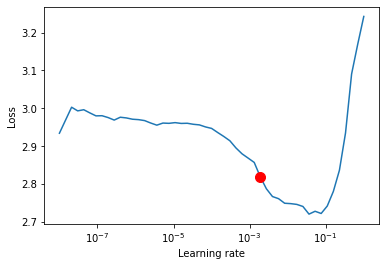

In [12]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

In [19]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

print(f'Suggested starting learning rate: {new_lr:.2e}')

Suggested starting learning rate: 1.91e-03


In [ ]:
model.hparams.lr = new_lr
config.model.optimizer.init_lr = new_lr

In [ ]:
%%prun
trainer = configure_trainer(config, log_gpu_memory=True) # limit_train_batches=2, limit_val_batches=2)

In [7]:
trainer.fit(model, datamodule=datamodule)
best_ckpt = trainer.callbacks[-1].best_model_path


def log_model_checkpoint_2_artifact(model, 
                                    ckpt_path: str,
                                    artifact_config,
                                    run=None):
    
    run = run or wandb.run
    os.makedirs(os.path.dirname(artifact_config.output_model_path), exist_ok=True)
    
    model = model.load_from_checkpoint(ckpt_path)
    model.save_model(artifact_config.output_model_path)

    output_model_artifact = wandb.Artifact(
                                    artifact_config.output_name,
                                    type=artifact_config.output_type,
                                    description=artifact_config.description,
                                    metadata=dict(**artifact_config,
                                                  **config.model)
                                    )
    output_model_artifact.add_dir(artifact_config.output_model_dir)
    run.log_artifact(output_model_artifact)

    print("Output Model Artifact Checkpoint path:\n", 
          artifact_config.output_model_path)
    

    
log_model_checkpoint_2_artifact(model, 
                                ckpt_path: str,
                                artifact_config=config.wandb.output_artifacts[0],
                                run=run)

    
    
#     model = model.load_from_checkpoint(ckpt_path)

#     os.makedirs(os.path.dirname(config.wandb.model_artifact.output_model_path), exist_ok=True)
#     model.save_model(config.wandb.model_artifact.output_model_path)

#     output_model_artifact = wandb.Artifact(
#                                     config.wandb.model_artifact.output_name,
#                                     type=config.wandb.model_artifact.output_type,
#                                     description=config.wandb.model_artifact.description,
#                                     metadata=dict(**config.wandb.model_artifact,
#                                                   **config.model)
#                                     )
#     output_model_artifact.add_dir(config.wandb.model_artifact.output_model_dir)
#     run.log_artifact(output_model_artifact)
#     run.finish()

#     print("BEST MODEL:\n", config.wandb.model_artifact.output_model_path)

#     wandb.run

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

   | Name          | Type              | Params | In sizes          | Out sizes        
---------------------------------------------------------------------------------------------
0  | relu          | ReLU              | 0      | [2, 64, 112, 112] | [2, 64, 112, 112]
1  | conv1         | Conv2d            | 9.4 K  | [2, 3, 224, 224]  | [2, 64, 112, 112]
2  | bn1           | BatchNorm2d       | 128    | [2, 64, 112, 112] | [2, 64, 112, 112]
3  | maxpool       | MaxPool2d         | 0      | [2, 64, 112, 112] | [2, 64, 56, 56]  
4  | layer1        | Sequential        | 215 K  | [2, 64, 56, 56]   | [2, 256, 56, 56] 
5  | layer2        | Sequential        | 1.2 M  | [2, 256, 56, 56]  | [2, 512, 28, 28] 
6  | layer3        | Sequential        | 7.1 M  | [2, 512, 28, 28]  | [2, 1024, 14, 14]
7  | layer4        | Sequential        | 15.0 M | [2, 1024, 14, 14] | [2, 2048, 7, 7] 

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)




Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  1782.5         	|  100 %          	|
------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  196.62         	|9              	|  1769.6         	|  99.276         	|
get_train_batch                    	|  2.1554         	|603            	|  1299.7         	|  72.914         	|
run_training_batch                 	|  0.1132         	|603            	|  68.262         	|  3.8295         	|
model_forward                      	|  0.11245        	|603            	|  67.81          	|  3.8041         	|
training_step_end                  	|  0.

2048 2097152


wandb: Adding directory to artifact (/media/data/jacob/wandb_cache/artifacts/models/resnet50:v0/PNAS_family_100_1024_trained)... Done. 0.6s


val/batch_idx,16
val/acc/top1,0.90395
val/acc/top3,0.9774
val/precision/top1,0.89724
val/recall/top1,0.89494
_runtime,1796
_timestamp,1621576966
_step,959
epoch,8
train/batch_idx,66
train_loss_step,0.49332


val/batch_idx,▁▁▃▅▇▁▃▅▆█▂▄▆█▂▄▅▇▁▃▄▆█▂▄▅▇▁▃▅▇▁▃▅▆█▂▄▆█
val/acc/top1,▁▆▅▇▆▇▇▆▆▆▆▇█▆▇█▇▇▇▇▇▇▇▇█▇▇▇▇██▇█▇▇▇▇███
val/acc/top3,▁▇▇▇▆██▇▇▇█▇█▇██▇███████████████████████
val/precision/top1,▁▅▄▅▃▆▆▄▅▆▅▆▆▇▆▆▆▆▆▆▅▆█▇▆▆█▇▆▇▆▇▇▆▇█▇▆▆█
val/recall/top1,▁▅▄▅▄▆▆▄▆▆▅▆▇▆▆▇▆▆▆▆▅▆▇▆▆▆█▇▆▇▆▇▇▆▆█▇▇▇█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇█████
train/batch_idx,▂▃▄▆█▂▄▆▇▂▃▅▆█▂▄▆█▂▄▅▆▁▃▄▆█▂▄▆▇▁▃▅▆█▃▄▆█
train_loss_step,▇█▄▅▃▄▂▁▁▂▁▂


BEST MODEL:
 /media/data/jacob/wandb_cache/artifacts/models/resnet50:v0/PNAS_family_100_1024_trained/best.ckpt
 

         24347237 function calls (23975123 primitive calls) in 1798.399 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    69751  212.231    0.003  212.231    0.003 {method 'decode' of 'ImagingDecoder' objects}
    24382  177.450    0.007  177.450    0.007 {built-in method io.open}
    35833  165.507    0.005  165.507    0.005 {method 'float' of 'torch._C._TensorBase' objects}
    23991  164.184    0.007  164.184    0.007 {method 'div' of 'torch._C._TensorBase' objects}
    42631  155.458    0.004  155.458    0.004 {method 'clone' of 'torch._C._TensorBase' objects}
    23991  151.515    0.006  151.515    0.006 {method 'div_' of 'torch._C._TensorBase' objects}
    23991  148.773    0.006  148.773    0.006 {method 'sub_' of 'torch._C._TensorBase' objects}
     5092  143.945    0.028  143.945    0.028 {built-in method stack}
    23991  106.090    0.004  106.090    0.004 {method 'contiguous' of 'torch._C._TensorBase' objects}


In [8]:
trainer = configure_trainer(config, log_gpu_memory=True)#, limit_train_batches=2, limit_val_batches=2)
trainer.fit(model, datamodule=datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



   | Name          | Type              | Params | In sizes          | Out sizes        
---------------------------------------------------------------------------------------------
0  | relu          | ReLU              | 0      | [2, 64, 112, 112] | [2, 64, 112, 112]
1  | conv1         | Conv2d            | 9.4 K  | [2, 3, 224, 224]  | [2, 64, 112, 112]
2  | bn1           | BatchNorm2d       | 128    | [2, 64, 112, 112] | [2, 64, 112, 112]
3  | maxpool       | MaxPool2d         | 0      | [2, 64, 112, 112] | [2, 64, 56, 56]  
4  | layer1        | Sequential        | 215 K  | [2, 64, 56, 56]   | [2, 256, 56, 56] 
5  | layer2        | Sequential        | 1.2 M  | [2, 256, 56, 56]  | [2, 512, 28, 28] 
6  | layer3        | Sequential        | 7.1 M  | [2, 512, 28, 28]  | [2, 1024, 14, 14]
7  | layer4        | Sequential        | 15.0 M | [2, 1024, 14, 14] | [2, 2048, 7, 7]  
8  | stem          | Sequential        | 9.5 K  | [2, 3, 224, 224]  | [2, 64, 56, 56]  
9  | features      | Sequ

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  472.66         	|  100 %          	|
------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  154.6          	|3              	|  463.79         	|  98.122         	|
get_train_batch                    	|  2.1313         	|169            	|  360.19         	|  76.204         	|
run_training_batch                 	|  0.09482

1

## Test the model

In [9]:
##########################################
##########################################

fix_catalog_number = "PNAS" in config.dataset.name
trainer = configure_trainer(config) #, limit_test_batches=2)

test_results = test_model(trainer,
                          model,
                          output_model_artifact,
                          datamodule,
                          config,
                          fix_catalog_number=fix_catalog_number)



wandb.finish()
print(trainer.current_epoch, test_results)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


val/batch_idx,16
val/acc/top1,0.91525
val/acc/top3,0.97363
val/precision/top1,0.90252
val/recall/top1,0.89489
_runtime,472
_timestamp,1621577455
_step,250
epoch,2
train/batch_idx,34
train_loss_step,0.099


val/batch_idx,▁▁▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
val/acc/top1,▅▆▇▇▇▃▆█▅▇▇▅▅▅▇▇▇▆▃▆▆▇▇▅▆▇▅▇█▅▅▇▇▆▇▇▁▆
val/acc/top3,█▇█▇█▇▅█▅▇██▅▇███▇▁▇███▇▅█▄▇█▇▇▇███▇▁▇
val/precision/top1,▄▄▄▅▆▄▄▇▅▅▅▄▆▄▅▆▇▅▂█▄▆▆▅▄▇▅▅▆▄▅▄▅▅▇▅▁█
val/recall/top1,▄▅▅▆▆▄▄▇▅▆▆▃▅▅▅▆▇▅▂█▄▆▆▅▄▇▅▆▆▄▅▅▅▅▇▅▁█
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,▁▁▁▁▁▁▅▅▅▅▅█
train/batch_idx,▁▁▂▂▃▃▄▄▅▅▆▆▇▇▇█▁▂▂▂▃▃▄▄▅▅▆▆▇▇██▁▂▂▃▃▃▄▅
train_loss_step,█▄▁


wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Downloading large artifact resnet50_output:latest, 90.18MB. 1 files... Done. 0:0:0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc/top1': 0.6468373537063599,
 'test/acc/top3': 0.8588102459907532,
 'test/precision/top1': 0.650568425655365,
 'test/recall/top1': 0.5781211256980896,
 'test_loss': 1.350639820098877}
--------------------------------------------------------------------------------


FileNotFoundError: [Errno 2] No such file or directory: '/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/val'

# End

# Notes


### Left to do 5-16-2021

1. trainer.fit ***
2. trainer.test ***

3. Refactor ValLog Callback to log PyTorch Lightning predictions + per-class scores *****

4. Add data tests for WandB downloaded data \*\*\*

    4a. Implement Data Drift framework!!!
    
5. Add Salient Map interpretability callback \*\*\*
    * https://github.com/MisaOgura/flashtorch
    
priority: \*, \*\*,\*\*\*, ****, *****

In [8]:
import torch
from GPUtil import showUtilization as gpu_usage

def test_pytorch_gpu_empty_cache(num_GB_2_gpu=10):
    print("Initial GPU Usage")
    gpu_usage()
    tensorList = []
    for x in range(10):
        tensorList.append(torch.randn(int(10e6), num_GB_2_gpu).cuda())   # reduce the size of tensor if you are getting OOM
        
        gpu_usage()

    print("GPU Usage after allocating a bunch of Tensors")
    gpu_usage()
    del tensorList
    print("GPU Usage after deleting the Tensors")
    gpu_usage()

    print("GPU Usage after emptying the cache")
    torch.cuda.empty_cache()
    gpu_usage()
    
    
    
test_pytorch_gpu_empty_cache(12)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

## Done

In [9]:
# from tqdm.auto import trange
# def log_predictions(trainer, model, datamodule, subset="test", fix_catalog_number=True):
    
#     datamodule.setup(stage="predict")
#     batches = trainer.predict(model, datamodule=datamodule)


#     x, y_logit, y_true, img_paths = list(np.concatenate(i) for i in zip(*batches))
#     loss_func = torch.nn.CrossEntropyLoss(reduction='none')

#     y_true = torch.from_numpy(y_true).to(dtype=torch.long)
#     y_logit = torch.from_numpy(y_logit)

#     loss = loss_func(y_logit, y_true)
#     idx = np.argsort(loss)

#     y_pred = torch.argmax(y_logit, -1)
#     y_score = y_logit.softmax(1)

#     x, y_logit, y_true, y_pred, img_paths, loss, y_score = (x[idx],
#                                                             y_logit[idx],
#                                                             y_true[idx],
#                                                             y_pred[idx],
#                                                             img_paths[idx],
#                                                             loss[idx],
#                                                             y_score[idx])

#     columns = ['catalog_number',
#                'image',
#                'guess',
#                'truth']
#     for j, class_name in enumerate(datamodule.classes):
#         columns.append(f'score_{class_name}')

#     x = torch.from_numpy(x).permute(0,2,3,1)
#     prediction_rows = []
#     x = (255 * (x - x.min()) / (x.max() - x.min())).numpy().astype(np.uint8)
#     for i in trange(len(y_pred)):
#         labels = get_labels_from_filepath(path=img_paths[i],
#                                           fix_catalog_number=fix_catalog_number)
#         row = [
#                 labels['catalog_number'],
#                 wandb.Image(x[i,...]),
#                 datamodule.classes[y_pred[i]],
#                 datamodule.classes[y_true[i]]
#         ]

#         for j, score_j in enumerate(y_score[i,:].tolist()):
#             row.append(np.round(score_j, 4))
#         prediction_rows.append(row)


#     prediction_table = wandb.Table(data=prediction_rows, columns=columns)
#     prediction_artifact = wandb.Artifact(f"{subset}_predictions-{wandb.run.id}", 
#                                          type="predictions")
#     prediction_artifact.add(prediction_table, f"{subset}_predictions")
#     wandb.run.log_artifact(prediction_artifact)

# log_predictions(trainer, model, datamodule, subset = "init", fix_catalog_number=True)

# y_logit, y_true, img_paths = [], [], []

# for batch in batches:
#     y_logit.append(batch[0])
#     y_true.append(batch[1])
#     img_paths.append(batch[2])



# gathered = list(zip(*batches))
# (gathered[0][0])

# y_logit = np.concatenate(y_logit, axis=0)
# y_true = np.concatenate(y_true, axis=0)
# img_paths = np.concatenate(img_paths, axis=0)

# print(y_logit.shape,y_true.shape,img_paths.shape)

# i = 1200
# print(y_logit[i:i+100,:],y_true[i:i+100],img_paths[i:i+100])

# np.concatenate

# # y_logit = torch.cat(y_logit, dim=0)
# # y_true = torch.cat(y_true, dim=0)
# # img_paths = torch.cat(img_paths, dim=0)

# print(type(results_init),
# len(results_init))



# # pp(results_init[0][0].shape, results_init[0][1].shape, (results_init[0][2]))
# i = 80

# pp(results_init[i][0].shape, results_init[i][1], (results_init[i][2]))

In [13]:
#         config.wandb.model_artifact.output_model_path = Path(config.wandb.model_artifact.output_model_dir,
#                                                              config.wandb.model_artifact.version,
#                                                              f"epoch_{trainer.current_epoch}" \
#                                                             + f"test_macro_acc={test_results['test/acc/top1']}")
#         os.makedirs(os.path.dirname(config.wandb.model_artifact.output_model_path), exist_ok=True)
#         model.save_model(config.wandb.model_artifact.output_model_path)


#         model_artifact = wandb.Artifact(
#                                         config.wandb.model_artifact.name+"_output", # ==config.model.name
#                                         type=config.wandb.model_artifact.output_type,
#                                         description=config.wandb.model_artifact.description,
#                                         metadata=dict(version=config.wandb.model_artifact.version,
#                                                       **config.model)
#                                         )
#         model_artifact.add_dir(os.path.dirname(config.wandb.model_artifact.output_model_path))
#         run.log_artifact(model_artifact)


#     log_predictions(trainer, model, datamodule, subset = "test", fix_catalog_number=fix_catalog_number)
    
#     run.finish()
    
#     return test_results

In [36]:
# # path = "/media/data/jacob/wandb_cache/artifacts/models/resnet50:v0/trained/best.ckpt"
    
# # loaded = model.load_state_dict(torch.load(path))



# # for n, m in model.classifier.named_modules():
# #     print(n, type(m))
# #     for p in m.parameters():

# for n, p in model.classifier.named_parameters():
#     print(n, p.shape, p.norm().detach())
    
    
    
# model.reset_classifier(config.model.num_classes,'avg')

# for n, p in model.classifier.named_parameters():
#     print(n, p.shape, p.norm().detach())


# loaded = torch.load("/media/data/jacob/wandb_cache/artifacts/models/resnet50:v0/trained/best.ckpt")
# loaded.keys()

In [7]:
# model.load_model(Path(config.wandb.model_artifact.init_model_dir,
#                       config.wandb.model_artifact.version))

# # log initial model before training (for illustration purposes)
# model_artifact.add_dir(config.wandb.model_artifact.init_model_dir)
# run.log_artifact(model_artifact)

# train_dataloader = datamodule.train_dataloader()
# batch_x, batch_y = next(iter(train_dataloader))
# print(batch_x.shape, batch_y.shape)

# datamodule.batch_size = 48
# train_dataloader = datamodule.train_dataloader()
# batch_x, batch_y = next(iter(train_dataloader))
# print(batch_x.shape, batch_y.shape)

# batch_x.shape

# batch_y

In [ ]:
# # EXPERIMENT CONFIG
# #------------------------
# # Core globals to modify
# # hyperparams set low for demo/training speed
# # if you set these higher, be mindful of how many items are in
# # the dataset artifacts you chose by setting the SIZE at the top
# NUM_TRAIN = BALANCED_SPLITS["train"]*10
# NUM_VAL = BALANCED_SPLITS["val"]*10
# NUM_EPOCHS = 3 # set low for demo purposes, try 3, 5, or as many as you like
# NUM_LOG_BATCHES = 16 # enforced max for this is ceil(NUM_VAL/batch_size)

# # ARTIFACTS CONFIG
# #------------------------
# TRAIN_DATA_AT = PREFIX + "_80-10-10_" + str(TOTAL_IMAGES) # training data artifact to load

# MODEL_NAME = "iv3_trained"
# INIT_MODEL_DIR = "init_model_keras_iv3" # folder in which to save initial, untrained model
# FINAL_MODEL_DIR = "trained_keras_model_iv3" # folder in which to save the final, trained model

# CFG = {
#   "num_train" : NUM_TRAIN,
#   "num_val" : NUM_VAL,
#   "num_classes" : 10,
#   "fc_size" : 1024,
#   "epochs" : NUM_EPOCHS,
#   "batch_size" : 32,
#   # inceptionV3 settings
#   "img_width" : 299,
#   "img_height": 299
# }


# max_log_batches = int(np.ceil(float(CFG["num_val"])/float(CFG["batch_size"]))) # number of validation data batches to log/use when computing metrics at the end of each epoch
# CFG["num_log_batches"] = min(max_log_batches, NUM_LOG_BATCHES)

# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.callbacks import Callback
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from wandb.keras import WandbCallback


# def finetune_inception_model(fc_size, num_classes):
#     """Load InceptionV3 with ImageNet weights, freeze it,
#     and attach a finetuning top for this classification task"""
#     # load InceptionV3 as base
#     base = InceptionV3(weights="imagenet", include_top="False")
#     # freeze base layers
#     for layer in base.layers:
#         layer.trainable = False
#     x = base.get_layer('mixed10').output 

#     # attach a fine-tuning layer
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(fc_size, activation='relu')(x)
#     guesses = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs=base.input, outputs=guesses)
#     model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# def train():

#     """ Main training loop which freezes the InceptionV3 layers of the model
#     and only trains the new top layers on the new data. A subsequent training
#     phase might unfreeze all the layers and finetune the whole model on the new data""" 
#     run = wandb.init(project=PROJECT_NAME, job_type="train", config=CFG)
#     cfg = wandb.config

#     # locate and download training and validation data
#     data_at = TRAIN_DATA_AT + ":latest"
#     data = run.use_artifact(data_at, type="balanced_data")
#     data_dir = data.download()
#     train_dir = os.path.join(data_dir, "train")
#     val_dir = os.path.join(data_dir, "val")

#     # create train and validation data generators
#     train_datagen = ImageDataGenerator(
#                                        rescale=1. / 255,
#                                        shear_range=0.2,
#                                        zoom_range=0.2,
#                                        horizontal_flip=True)
#     val_datagen = ImageDataGenerator(rescale=1. / 255)

#     train_generator = train_datagen.flow_from_directory(
#                                                         train_dir,
#                                                         target_size=(cfg.img_width, cfg.img_height),
#                                                         batch_size=cfg.batch_size,
#                                                         class_mode='categorical')

#     val_generator = val_datagen.flow_from_directory(
#                                                     val_dir,
#                                                     target_size=(cfg.img_width, cfg.img_height),
#                                                     batch_size=cfg.batch_size,
#                                                     class_mode='categorical',
#                                                     shuffle=False)

#     # instantiate model and callbacks
#     model = finetune_inception_model(cfg.fc_size, cfg.num_classes)

#     # log initial model before training (for illustration purposes)
#     model_artifact = wandb.Artifact(
#                                     "iv3", type="model",
#                                     description="unmodified inception v3",
#                                     metadata=dict(cfg))
#     model.save(INIT_MODEL_DIR)
#     model_artifact.add_dir(INIT_MODEL_DIR)
#     run.log_artifact(model_artifact)
#     callbacks = [WandbCallback(), ValLog(val_generator, cfg.num_log_batches)]

#     # train!
#     model.fit(
#               train_generator,
#               steps_per_epoch = cfg.num_train // cfg.batch_size,
#               epochs=cfg.epochs,
#               validation_data=val_generator,
#               callbacks = callbacks,
#               validation_steps = cfg.num_val // cfg.batch_size)

#     # save trained model as artifact
#     trained_model_artifact = wandb.Artifact(
#             MODEL_NAME, type="model",
#             description="trained inception v3",
#             metadata=dict(cfg))

#     model.save(FINAL_MODEL_DIR)
#     trained_model_artifact.add_dir(FINAL_MODEL_DIR)
#     run.log_artifact(trained_model_artifact)
#     run.finish()

# class ValLog(Callback):
#   """ Custom callback to log validation images
#   at the end of each training epoch"""
#   def __init__(self, generator=None, num_log_batches=1):
#     self.generator = generator
#     self.num_batches = num_log_batches
#     # store full names of classes
#     self.flat_class_names = [k for k, v in generator.class_indices.items()]

#     def on_epoch_end(self, epoch, logs={}):
#         # collect validation data and ground truth labels from generator
#         val_data, val_labels = zip(*(self.generator[i] for i in range(self.num_batches)))
#         val_data, val_labels = np.vstack(val_data), np.vstack(val_labels)

#         # use the trained model to generate predictions for the given number
#         # of validation data batches (num_batches)
#         val_preds = self.model.predict(val_data)
#         true_ids = val_labels.argmax(axis=1)
#         max_preds = val_preds.argmax(axis=1)

#         # save validation predictions as an artifact
#         val_res_at = wandb.Artifact("val_pred_" + wandb.run.id, "val_epoch_preds")
#         columns=["id", "image", "guess", "truth"]
#         for a in self.flat_class_names:
#           columns.append("score_" + a)
#         val_dt = wandb.Table(columns = columns)

#         # log image, predicted and actual labels, and all scores
#         for filepath, img, top_guess, scores, truth in zip(self.generator.filenames,
#                                                            val_data, 
#                                                            max_preds, 
#                                                            val_preds,
#                                                            true_ids):
#           img_id = filepath.split('/')[-1].split(".")[0]
#           row = [img_id, wandb.Image(img), 
#                  self.flat_class_names[top_guess], self.flat_class_names[truth]]
#           for s in scores.tolist():
#             row.append(np.round(s, 4))
#           val_dt.add_data(*row)
#         val_res_at.add(val_dt, "val_epoch_res")
#         wandb.run.log_artifact(val_res_at)

In [ ]:
# from pytorch_lightning.loggers import TestTubeLogger
# logger = TestTubeLogger('.', create_git_tag=True)

# Previous torchmetrics scratch code

In [2]:
from torchmetrics.classification.stat_scores import StatScores
from torchmetrics.classification.precision_recall import Precision, Recall
from torch import Tensor, tensor

_mc_k_target = tensor([0, 1, 2, 1])
_mc_k_pred = tensor([[0.35, 0.4, 0.25], [0.1, 0.5, 0.4], [0.2, 0.1, 0.7], [0.2, 0.3, 0.5]])
_mc_k_pred_2 = tensor([[0.2, 0.4, 0.4], [0.1, 0.5, 0.4], [0.2, 0.3, 0.5], [0.48, 0.27, 0.25]])

pred, target = _mc_k_pred, _mc_k_target
pred_2 = _mc_k_pred_2

####################

num_classes=3
reduce=None#'macro'

stat_metrics = StatScores(num_classes=num_classes, reduce='macro')#reduce)
precision = Precision(num_classes=num_classes, top_k=1, average=reduce)
recall = Recall(num_classes=num_classes, top_k=1, average=reduce)

def update_metrics(pred, target):
    return [stat_metrics(pred, target), precision(pred, target), recall(pred, target)]

def compute_metrics():
    return [stat_metrics.compute(), precision.compute(), recall.compute()]


batch_stat_metrics, batch_precision, batch_recall = update_metrics(pred, target)

batch_stat_metrics, batch_precision, batch_recall = update_metrics(pred, target)
batch_stat_metrics, batch_precision, batch_recall = update_metrics(pred_2, target)

print('OFFICIAL torchmetrics\n')
print('batch:')
print(batch_stat_metrics, batch_precision, batch_recall,'\n')
epoch_metrics = compute_metrics()
print('epoch:\n',
      f'stat_metrics:\n{epoch_metrics[0]},\n',
      f'precision:\n{epoch_metrics[1]},\n',
      f'recall:\n{epoch_metrics[2]}')
print('=='*10)
print('TEST manual metrics\n')
print('epoch:')
for i in range(len(epoch_metrics[0])):
    tp, fp, tn, fn, total = epoch_metrics[0][i]
    epoch_precision = tp / (tp + fp)
    epoch_recall = tp / (tp + fn)
    print(f'precision: {epoch_precision}')
    print(f'recall: {epoch_recall}')

# for class_i in zip(stat_metrics, precision, recall):
#     print(class_i)

def print_stats(tp, fp, tn, fn, total):
    recall = tp / (total)
    print(f"tp:{tp}, fp:{fp}, tn:{tn}, fn:{fn}, total:{total}")
    print(f"recall:{recall}")

print(target.shape, preds.shape)

sum_preds = torch.zeros_like(preds[0,:])
count_preds = torch.zeros_like(preds[0,:])
print(sum_preds, count_preds)

batch_results = stat_metrics(preds, target)
print(batch_results)
epoch_results = stat_metrics.compute()
for tp, fp, tn, fn, total in epoch_results:
    print_stats(tp, fp, tn, fn, total)
    sum_preds += preds.sum(dim=0)
    count_preds += preds.shape[0]
    
print(f'Avg preds: {sum_preds/count_preds}')
    

batch_results = stat_metrics(preds_2, target)
print(batch_results)
epoch_results = stat_metrics.compute()
for tp, fp, tn, fn, total in epoch_results:
    print_stats(tp, fp, tn, fn, total)

# End

In [48]:
# batch_results = stat_metrics(preds, target)

# for tp, fp, tn, fn, totals in batch_results:
#     recall = tp / (totals)
    
#     print(f"tp:{tp}, fp:{fp}, tn:{tn}, fn:{fn}, totals:{totals}")
#     print(f"recall:{recall}")

# print(stat_metrics.compute())

# datamodule.train_dataset

# datamodule.train_dataset[0][0].shape

# from rich import inspect

# train_dataloader = datamodule.train_dataloader()
# train_dataset = datamodule.train_dataset

# classes = train_dataset.classes
# # train_dataset.sample_params
# train_dataset.samples[:2]

In [ ]:
# if SIZE == "TINY":
#     src_url = "https://storage.googleapis.com/wandb_datasets/nature_100.zip"
#     src_zip = "nature_100.zip"
#     DATA_SRC = "nature_100"
#     IMAGES_PER_LABEL = 10
#     BALANCED_SPLITS = {"train" : 8, "val" : 1, "test": 1}
# elif SIZE == "MEDIUM":
#     src_url = "https://storage.googleapis.com/wandb_datasets/nature_1K.zip"
#     src_zip = "nature_1K.zip"
#     DATA_SRC = "nature_1K"
#     IMAGES_PER_LABEL = 100
#     BALANCED_SPLITS = {"train" : 80, "val" : 10, "test": 10}
# elif SIZE == "LARGE":
#     src_url = "https://storage.googleapis.com/wandb_datasets/nature_12K.zip"
#     src_zip = "nature_12K.zip"
#     DATA_SRC = "inaturalist_12K/train" # (technically a subset of only 10K images)
#     IMAGES_PER_LABEL = 1000
#     BALANCED_SPLITS = {"train" : 800, "val" : 100, "test": 100}

# %%capture
# !curl -SL $src_url > $src_zip
# !unzip $src_zip



# import os
# from random import shuffle
# import numpy as np
# import wandb

# # source directory for all raw data
# SRC = DATA_SRC
# PREFIX = "inat" # convenient for tracking local data
# PROJECT_NAME = "dsviz_demo"

# # number of images per class label
# # the total number of images is 10X this (10 classes)
# TOTAL_IMAGES = IMAGES_PER_LABEL * 10

In [5]:
# os.path.join(*[config.wandb.artifact_root_dir,"models",config.model.name])

# import wandb
# api = wandb.Api()
# artifact = api.artifact(config.wandb.input_artifact.uri)
# artifact

# print(config.wandb.input_artifact.uri)

# run = wandb.init(**config.wandb.init)

# artifact = run.use_artifact(artifact)#, type=config.wandb.input_artifact.type)

# artifact_dir = artifact.download()
# os.path.abspath(artifact_dir)
# # files = artifact.file()

# print(config.wandb.input_artifact.uri)

# wandb.finish()

# os.environ["WANDB_PROJECT"] = config.wandb.init.project

# import wandb
# run = wandb.init(entity='jrose', project=config.wandb.init.project, job_type=config.wandb.init.job_type, config=config)
# artifact = run.use_artifact('jrose/image_classification_datasets/PNAS_family_100_1024:v0', type='raw_data')
# artifact_dir = artifact.download()
# artifact_dir = os.path.abspath(artifact_dir)


# config.model_name = 'resnet50'
# config.dataset_name = 'PNAS_family_100_1024'
# # config.dataset_name = 'Extant_family_10_512'
# config.normalize = True
# config.num_workers = 4
# config.batch_size = 48
# config.debug=False

# from box import Box


# data_config = Box(dict(name="PNAS_family_100_1024",
#                    batch_size=32,
# #                    val_split=0.2,
#                    num_workers=4,
#                    seed=389,
#                    debug=False,
#                    normalize=True,
#                    image_size=1024,
#                    channels=3,
#                    dataset_dir=artifact_dir))

In [10]:
# # [source] https://wandb.ai/stacey/evalserver_answers_2/runs/2nrnmyk8/code


# # Given the per-class metrics, compute the per-category metrics
# # (aggregate over the component classes, e.g. category human = class person and class rider)
# def per_category_metrics(ious, fps, fns):
#   metrics = {}
#   for metric_name, metric_type in zip(["iou", "fps", "fns"], [ious, fps, fns]):
#     for category_name, ids in util.CITYSCAPE_IDS.items():
#       category_metric = np.mean([metric_type[class_id] for class_id in ids])
#       metrics["category/" + metric_name + "_" + category_name] = category_metric
#   # average across categories, per metric
#   for metric in ["category/iou", "category/fps", "category/fns"]:
#     metric_vals = [v for k, v in metrics.items() if k.startswith(metric)]
#     metrics["mean_category/" + metric.split("/")[1]] = np.mean(metric_vals)
#   return metrics

In [ ]:
# # if this is a substantially different dataset, give it a new name
# # this will create a whole new placeholder (Artifact) for this split
# # instead of just incrementing a version of the old data split
# run = wandb.init(project=PROJECT_NAME, job_type="data_split")

# SPLIT_DATA_AT = "_".join([PREFIX, "80-10-10", str(TOTAL_IMAGES)])

# # create balanced train, val, test splits
# # each count is the number of images per label
# SPLIT_COUNTS = BALANCED_SPLITS

# # find the most recent ("latest") version of the full raw data
# # you can of course pass around programmatic aliases and not string literals
# # note: RAW_DATA_AT is defined in the previous cell—if you're running
# # just this step, you may need to hardcode it
# data_at = run.use_artifact(RAW_DATA_AT + ":latest")
# # download it locally (for illustration purposes/across hardware; you can
# # also sync/version artifacts by reference)
# data_dir = data_at.download()

# # Create new dataset to use in training

# data_split_at = wandb.Artifact(SPLIT_DATA_AT, type="balanced_data")
# # create a table with columns we want to track/compare
# preview_dt = wandb.Table(columns=["id", "image", "label", "split"])

# labels = os.listdir(data_dir)
# for l in labels:
#   if l.startswith("."): # skip non-label file
#     continue
#   imgs_per_label = os.listdir(os.path.join(data_dir, l))
#   shuffle(imgs_per_label)
#   start_id = 0
#   for split, count in SPLIT_COUNTS.items():
#     # take a subset
#     split_imgs = imgs_per_label[start_id:start_id+count]
#     for img_file in split_imgs:
#       f_id = img_file.split(".")[0]
#       full_path = os.path.join(data_dir, l, img_file)
#       # add file to artifact by full path
#       # note: pass the label to the name parameter to retain it in
#       # the data structure 
#       data_split_at.add_file(full_path, name = os.path.join(split, l, img_file))
#       # add a preview of the image
#       if split != "test":
#         preview_dt.add_data(f_id, wandb.Image(full_path), l, split)
#     start_id += count

# # log artifact to W&B
# data_split_at.add(preview_dt, "data_split")
# run.log_artifact(data_split_at)
# run.finish()

### Dataset creation workflow outsourced to script in prj_contrastive_learning

In [3]:
## Register PNAS dataset to WandB

# data_config = dict(name="PNAS_family_100_1024",
#                    batch_size=32,
#                    val_split=0.2,
#                    num_workers=4,
#                    seed=389,
#                    debug=False,
#                    normalize=True,
#                    image_size=1024,
#                    channels=3)

# wandb.init(project="image_classification_datasets",
#            job_type='create-dataset',
#            config=data_config)

# dataset_artifact = wandb.Artifact(data_config["name"],
#                                   type='raw_data')

# datamodule = PNASLightningDataModule(**data_config)
# datamodule.setup(stage='fit')
# datamodule.setup(stage='test')

# # classes = datamodule.classes

# register_raw_dataset(dataset=datamodule.train_dataset,
#                      artifact=dataset_artifact,
#                      subset='train',
#                      fix_catalog_number=True)


# register_raw_dataset(dataset=datamodule.val_dataset,
#                      artifact=dataset_artifact,
#                      subset='val',
#                      fix_catalog_number=True)


# register_raw_dataset(dataset=datamodule.test_dataset,
#                      artifact=dataset_artifact,
#                      subset='test',
#                      fix_catalog_number=True)

# wandb.log_artifact(dataset_artifact)

# wandb.finish()

########################################
########################################

## Register Extant dataset to WandB

# %%time

# data_config = dict(name="Extant_family_10_512",
#                    batch_size=32,
#                    val_split=0.2,
#                    num_workers=4,
#                    seed=5363,
#                    debug=False,
#                    normalize=True,
#                    image_size=512,
#                    channels=3)

# wandb.init(project="image_classification_datasets",job_type='create-dataset', config=data_config)
# dataset_artifact = wandb.Artifact(data_config["name"], type='raw_data')

# datamodule = ExtantLightningDataModule(**data_config)
# datamodule.setup(stage='fit')
# datamodule.setup(stage='test')

# train_dataloader = datamodule.train_dataloader()
# train_dataset = datamodule.train_dataset
# val_dataset = datamodule.val_dataset
# test_dataset = datamodule.test_dataset
# classes = datamodule.classes

# register_raw_dataset(dataset=train_dataset,
#                      artifact=dataset_artifact,
#                      subset='train')


# register_raw_dataset(dataset=val_dataset,
#                      artifact=dataset_artifact,
#                      subset='val')


# register_raw_dataset(dataset=test_dataset,
#                      artifact=dataset_artifact,
#                      subset='test')

# wandb.log_artifact(dataset_artifact)

# wandb.finish()

In [ ]:




# # if this is a substantially new dataset, give it a new name
# # this will create a whole new placeholder (Artifact) for this dataset
# # instead of just incrementing a version of the old dataset
# RAW_DATA_AT = "_".join([PREFIX, "raw_data", str(TOTAL_IMAGES)])
# run = wandb.init(project=PROJECT_NAME, job_type="upload")
# # create an artifact for all the raw data
# raw_data_at = wandb.Artifact(RAW_DATA_AT, type="raw_data")

# # SRC_DIR contains 10 folders, one for each of 10 class labels
# # each folder contains images of the corresponding class
# labels = os.listdir(SRC)
# for l in labels:
#   imgs_per_label = os.path.join(SRC, l)
#   if os.path.isdir(imgs_per_label):
#     # filter out "DS_Store"
#     imgs = [i for i in os.listdir(imgs_per_label) if not i.startswith(".DS")]
#     # randomize the order
#     shuffle(imgs)
#     img_file_ids = imgs[:IMAGES_PER_LABEL]
#     for f in img_file_ids:
#       file_path = os.path.join(SRC, l, f)
#       # add file to artifact by full path
#       raw_data_at.add_file(file_path, name=l + "/" + f)

# # save artifact to W&B
# run.log_artifact(raw_data_at)
# run.finish()